# Practical session: Neural networks

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In this lab we will implement the different elements that compose a neural network

# Data set

In the first part, we will try to predict the selling price of real estate in the city Boston.  
To do so we will use the classic boston house-prices dataset available directly in the machine learning libraryg [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html)  
So let's start by importing the dataset:

In [2]:
from sklearn.datasets import fetch_california_housing 
dataset = fetch_california_housing()

We will therefore try to predict the price of houses from 13 features presented [here](https://scikit-learn.org/stable/datasets/index.html#boston-dataset).   

Let's start by separating the dataset in 2:
* A learning set to train the model
* A test set to evaluate the learned model

Use [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)  from scikit-learn to separate the dataset as follows:
* X_train -> the features to train the model
* y_train -> prices to predict during learning
* X_test -> the features to test the model
* y_test -> labels to evaluate the model's predictions 

In [38]:
# %load solutions/boston_train_test_split.py
from sklearn.model_selection import train_test_split
import numpy as np

data = np.asarray(dataset.data, dtype='float32')[0:500,:]
target = np.asarray(dataset.target.reshape(-1, 1), dtype='float32')[0:500,:]

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=.2,random_state=42)


Among the best practices for improving the learning of neural networks, it is important to normalize the input data to obtain an average close to 0 and a variance to 1.
Use the [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) method of scikit-learn to normalize X_train and X_test as well as y_train and y_test:

In [4]:
# %load solutions/boston_scaler.py
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler()
X_tr= scaler.fit_transform(X_train)
X_ts = scaler.fit_transform(X_test)
y_tr = scaler.fit_transform(y_train)
y_ts = scaler.fit_transform(y_test)

# Neural networks

We are going to build our neural networks as successions of layers..  
We will distinguish, similarly to the most common frameworks (Tensorflow, Pytorch, Keras ...) two types of layers:
* weight and gradient layers
* activation layers 

Each layer will have:
* a forward method which receives as input a vector $x$ and apply a transformation to it that will serve as inputs for the following layers
* a backward method which receives as input gradients and backpropagate them to the previous layers 
* a layer_type argument used to define the type of layer

The following class defines the structure of a layer:

In [5]:
class Layer:
    def __init__(self):
        self.layer_type = 'abstract'

    def forward(self, inputs):
        pass
    
    def backward(self, grad):
        pass

A neural network will therefore be a class:
* containing a list of layers
* having a forward method (which will be in fact the composition of the forward methods of its layers) which for a vector x will provide a prediction
* and a backward method (composition of the backward methods of its layers) which will backpropagate the gradients from its last layer to its first layers.

![NeuralNetwork](layers.png)

# Layers

We will now implement the layers of our network.  
Let's start with the "linear" layers composed of weight $W$ and bias $b$.  
These layers receive a vector $x$ as input and return the result of $Wx + b$.

Complete the definition of the LinearLayer class:
* weights and biases will be stored in a dictionary named "params". The weights will be represented by a matrix $input \times output$ initialized uniformly between $[-0.1, 0.1]$ (you may use random.uniform function from numpy)
* implement the forward method (you can use the np.matmul function to calculate $Wx$),  it will be necessary to keep in memory the input vector which will be used when calling the backward method:

In [50]:
#%load solutions/layers.py
class Linear(Layer):
    def __init__(self, input_size, output_size):
        super().__init__()
        
        self.layer_type = 'linear'
        self.params ={}
        self.grads = {}
        #weights est la matrice [input x output] contenant les poids de la couche 
        self.params["weights"] = np.random.uniform(-.1,.1, size=(input_size,output_size))
        #biais est un vecteur de dimension: (output_size)
        self.params["bias"] = np.random.uniform(0,1,output_size)

    def forward(self, inputs):
        # outputs = inputs @ weights + biais
        #Nous devons garder en mémoire les inputs car ils seront utilisés dans la méthode backward
        self.inputs = inputs
        output = np.dot(inputs, self.params['weights']) + self.params['bias']
        self.output = output
        return self.output
    
    def backward(self, grad):
        # we need to sum gradients over the batch axis
        self.grads["weights"] = np.matmul(self.inputs.T, grad)
        self.grads["bias"] = np.sum(grad, axis=0)
        return np.matmul(grad, self.params["weights"])


Test your layer, the following cell should not return an error:

In [49]:
input_size, output_size = 10, 5
X = np.random.rand(input_size)
print(X.shape)
grads = np.random.rand(10,5)
print(grads.shape)
test_linear_layer = Linear(input_size, output_size)
assert test_linear_layer.forward(X).shape == (5,)
assert test_linear_layer.backward(grads).shape == (10,10)

(10,)
(10, 5)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 10 is different from 5)

## Activation Layers

We will now implement the activation functions used by neurons.
Implement an activation function and its derivative (for example the ReLU function: $f(x) = max(0,x)$:

In [23]:
# %load solutions/activations.py
def relu(x):
    # val = np.maximum(0,x)
    return np.maximum(0,x)
def relu_prime(x):
    return np.where(x>0,1.0,0.0)
   

Now implement the activation layers:  
They will be initialized with a function $f$ and its derivative

In [9]:
#%load  solutions/activation_layer.py
class Activation(Layer):
    def __init__(self, f, f_prime):
        super().__init__()
        self.layer_type = 'activation'
        self.f = f
        self.f_prime = f_prime

    def forward(self, inputs):
        #Nous devons garder en mémo.ire les inputs car ils seront utilisés dans la méthode backward
        self.intputs = inputs
        return self.f(inputs)
    
    def backward(self, grad):
        """ si y = f(x) et x = g(z)
        alors dy/dz = f'(x) * g'(z)
        Dans notre cas g'(z) correspond aux gradients en entrée
        """
        return self.f_prime(self.intputs) * grad

Test your activation layer, the following cell should not return an error

In [10]:
relu_layer = Activation(f=relu, f_prime=relu_prime)

#forward
x = np.array([-1, 5, -2, 6])
y = relu_layer.forward(x)
assert np.array_equal(y, np.array([0, 5, 0, 6]))

#backward
incomming_grads = np.array([-0.1, 0.6, -0.4, -0.1])
grads = relu_layer.backward(incomming_grads)
assert np.array_equal(grads, np.array([-0. ,  0.6, -0. , -0.1]))

## Neural network

We will now define the class that will be used to represent our neural networks.  
A neural network will have a list of layers and two methods: forward and backward.  

Complete the forward method and the backward method of the NeuralNetwork class by calling the forward and backward methods of the network layers:

In [39]:

class NeuralNetwork:
    def __init__(self, layers):
        self.layers = layers

    def forward(self, inputs):
        for i in self.layers[:-1]:
            inputs = i.forward(inputs)
        return Activation(f=relu,f_prime=relu_prime).forward(self.layers[-1].forward(inputs))
    
    def backward(self, grad):
        for i in reversed(self.layers):
            gr = i.backward(grad)
            grad = Activation(f=relu, f_prime=relu_prime).backward(gr)
        return grad
        
            

We now have all the elements that compose a neural network.  
Instantiate a neural network composedof 3 layers:
* an input layer receiving a dimension 13 vector and consisting of 40 neurons
* a hidden layer of 40 neurons
* an output layer consisting of a single neuron

In [40]:
# %load solutions/boston_network.py
L1 = Linear(input_size= 8,output_size= 40)
L2 = Linear(input_size=40,output_size=1)
# L3 = np.zeros(8)
net = NeuralNetwork([L1,L2])

Test your network on the test set:

--- (100, 1)
(100, 1)
1.9198401075601579


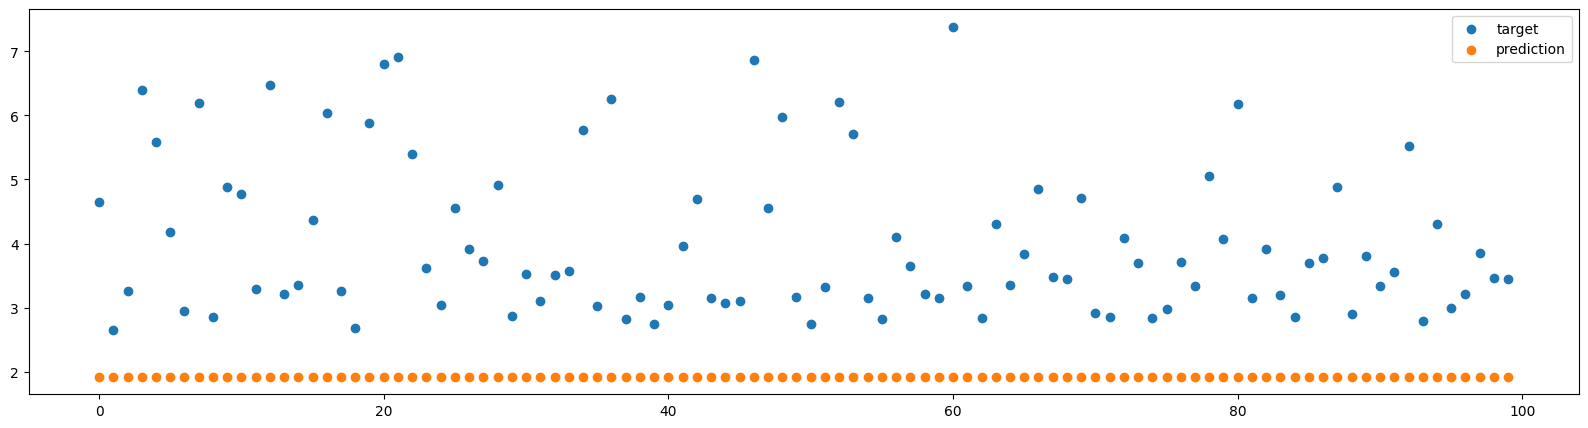

Bad pipe message: %s [b'd\x00\x9a\x83\x07K;v{\x02\x0fT\x86\xf1>\x1e\xd5\x06 p\xdf7\xb1%\xb5~\x80\xee\xcc\x05\xb9\xf3\xff&\xa6\xf2^2V\xb9f\x0b\xa0\x95\x84ZF\n\xe1\xb26\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00']
Bad pipe message: %s [b'\x0e\xe878']
Bad pipe message: %s [b'\xc7z\xbco\xe7qT{', b"\xef$\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0#\xc0'\x00g\x00@\xc0\n\xc0\x14\x009\x008\xc0\t\xc0\x13\x003\x002\x00\x9d\xc0\xa1\xc0\x9d\xc0Q\x00\x9c\xc0\xa0\xc0\x9c\xc0P\x00=\x00<\x005\x00/\x00\x9a\x00\x99\xc0\x07\xc0\x11\x00\x96\x00\x05\x00\xff\x01\x00\x00j\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00"]
Bad pipe message: %s [b'\xd0\x88\xeb\x0bb6\\\xef\x90\xf2']
Bad pipe message: %s [b'\xa7\x0e\xbc\xd9K\x84\x0

In [41]:
from sklearn.metrics import mean_absolute_error

y_pred = net.forward(X_test)
print('---',y_pred.shape)
print(y_test.shape)
print(mean_absolute_error(y_pred, y_test))
    
plt.figure(figsize=(20,5))
plt.scatter(range(len(y_test)), scaler.inverse_transform(y_test), label='target')
plt.scatter(range(len(y_test)), scaler.inverse_transform(y_pred), label='prediction')
plt.legend()

# Loss function

The network predictions are bad.  
This is normal, we haven't trained him yet.  
Let's start by implementing the loss function that the neural network will use in its learning.  
We are here in a regression problem, we will use the mean squared error to learn our model:

$$\sum_{i}^{n}\frac{(f(x_i) - y_i)^2}{n}$$  
Implement the loss function as well as its derivative which will be used during the back-propagation:

In [42]:
# %load solutions/mse.py
class MSE():

    def loss(self, y_pred, y_true):
        #returns a scalar
        return np.mean((y_pred - y_true)**2)
    
    def grad(self, y_pred, y_true):
        #returns a tensor of gradients
        return 2*(y_pred - y_true)/y_true.shape[0]

# Optimizer

We will now implement the optimization method used during learning.  
We will use here the stochastic gradient descent.  
The method is simple: for each step we will update the network parameters thanks to the following formula: suivante: $w_{t+1} = w_t - \eta \nabla$ où $\eta$ is the learning rate.

In [43]:
# %load solutions/sgd.py
class SGD():
    def __init__(self, lr=0.001):
        self.lr = lr
    
    def step(self, net):
        for layer in net.layers:
            if layer.layer_type == 'linear':
                for param, grad in zip(layer.params.values(), layer.grads.values()):
                    param-=self.lr*grad

# Fit function

t only remains to implement the fit function, which achieves an epoch of learning.
The function must:
* compute network predictions on the learning batch
* compute the loss
* compute the gradient of the loss
* re-propagate the gradients
* make an optimization step
* return loss

In [44]:
# %load solutions/fit.py
def fit(net, loss, optimizer, X, y):
    y_pred = net.forward(X)
    prediction_loss = loss.loss(y_pred,y)
    loss_grad = loss.grad(y_pred,y)
    net.backward(loss_grad)
    optimizer.step(net)
    
    return prediction_loss

We can now train our network:

In [51]:
optimizer = SGD(lr=0.01)
loss = MSE()
for i, (x, y) in enumerate(zip(X_train, y_train)):
    training_loss = fit(net, loss, optimizer, np.array([x]), np.array([y]))

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 40 is different from 1)

Plot the results of your training:

In [ ]:
y_pred = net.forward(X_test)
print(mean_absolute_error(y_pred, y_test))
    
plt.figure(figsize=(20,5))
plt.scatter(range(len(y_test)), scaler.inverse_transform(y_test), label='target')
plt.scatter(range(len(y_test)), scaler.inverse_transform(y_pred), label='prediction')
plt.legend()

# Digits

ENow let's try our class on a classification problem.
We will seek to classify handwritten figures from pixels. We will use for this the [digits dataset from scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html)  

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits

dataset = load_digits()

Display the first 10 elements of the dataset:

In [ ]:
#load  solutions/digits.py

Similar to the previous dataset, separate your data set in two and normalize the input vectors. (No need this time to normalize the y)

In [ ]:
# %load solutions/digits_preprocessing.py
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

data = np.asarray(dataset.data, dtype='float32')
target = np.asarray(dataset.target, dtype='int32')

X_train, X_test, y_train, y_test = ...

...
X_train = ...
X_test = ...

# Cross entropy

This time we are faced with a classification problem.  
The MSE loss function is no longer suitable for our problem.  
This time we will use the [cross-entropy.](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression) as a loss function:
$$ L = \frac{1}{N}\sum_{i=1}^{N}y_i \cdot log(\hat{y_i})$$  
With $\hat{y_i}$ the network prediction on which the softmax function is applied:
$$softmax_j(x) = \frac{e^x_j}{\sum_{k}e^x_k}$$

In [ ]:
def softmax(x):
    return np.exp(x) / np.exp(x).sum(axis=-1,keepdims=True)

class CrossEntropy():

    def loss(self, logits, y_true):
        logits_for_answers = logits[np.arange(len(logits)), y_true]
        xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
        return xentropy



    def grad(self, logits, y_true):
        ones_for_answers = np.zeros_like(logits)
        ones_for_answers[np.arange(len(logits)), y_true] = 1
        y_softmax = softmax(logits)
        return (- ones_for_answers + y_softmax) / logits.shape[0]

Instantiate a neural network capable of predicting the class of an image:

In [ ]:
#%load solutions/digits_net.py
...
net = ...
optimizer = SGD(lr=0.05)

Calculate the accuracy of your network on the test set. (You can use the function [acuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) from scikit-learn)

In [ ]:
#%load  solutions/accuracy1.py

The following function allows you to view our predictions

In [ ]:
def plot_prediction(net, sample_idx=range(3), classes=range(10)):
    
    for idx in sample_idx:
        plt.figure()
        logits = net.forward(X_test[idx])
        probas = softmax(logits)
        prediction = np.argmax(probas)

        fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

        ax0.imshow(scaler.inverse_transform(X_test[idx]).reshape(8, 8), cmap=plt.cm.gray_r,
                   interpolation='nearest')
        ax0.set_title("True image label: %d" % y_test[idx]);
        ax1.bar(classes, np.eye(len(classes))[y_test[idx]], label='true')
        ax1.bar(classes, probas, label='prediction', color="red")
        ax1.set_xticks(classes)

        ax1.set_title('Output probabilities (prediction: %d)'
                      % prediction)
        ax1.set_xlabel('Digit class')
        ax1.legend()

In [ ]:
plot_prediction(net, sample_idx=range(3))

This time, we will use mini-batches during our learning.
The following function iterates over mini-batches:

In [ ]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=True):
    assert inputs.shape[0] == targets.shape[0]
    if shuffle:
        indices = np.arange(inputs.shape[0])
        np.random.shuffle(indices)
    for start_idx in range(0, inputs.shape[0] - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

And the following function to realize a learning epoch using mini-batches:

In [ ]:
def fit_one_epoch(X, y_true):
    for x, y in iterate_minibatches(X, y_true, 32):
        training_loss = fit(net, loss, optimizer, x, y)
        
    return training_loss.mean()

Train your network over 15 epochs.  
At each epoch calculate your accuracy on the train set and on the test set and display them on the same graph once the training is over.

In [ ]:
#%load solutions/plot_accuracy.py

Display your accuracy on the test set and visualize your predictions using the plot_prediction function)

In [ ]:
# %load solutions/accuracy2.py

Try to display your confusion matrix by taking inspiration from [this code:](https://scikit-learn.org/dev/auto_examples/classification/plot_digits_classification.html#sphx-glr-auto-examples-classification-plot-digits-classification-py) 

In [ ]:
# %load solutions/confusion_matrix.py

Display the examples on which the network is mistaken:

In [ ]:
# %load solutions/plot_errors.py